# 🎮 GameRx | Genre Merge & Cleaning  

This notebook connects **Steam reviews** with their **game genres** by merging two cleaned datasets.

#### 📥 Inputs
- `03_steam_reviews.csv` → cleaned reviews  
- `02_games_metadata_genre_ready.csv` → metadata with genre tags  

#### ❓ What happens here
- Merge both files using `AppID`  
- Keep reviews that match a game with genres  
- Check the match rate  
- Look for any missing genre info  

#### Goal
Build one **genre-enriched dataset** with:

- `primary_genre`  
- `genre_list`  
- `genre_count`  

Ready for emotional analysis in the next steps.

### Table of Contents

1. [Import Libraries](#1-import-libraries)  
2. [Load Datasets](#2-load-datasets)  
3. [Harmonize Schemas](#3-harmonize-schemas)  
4. [Check Keys & Duplicates](#4-check-keys--duplicates)  
5. [Merge Reviews + Genres](#5-merge-reviews--genres)  
6. [Post-Merge Checks](#6-post-merge-checks)  
7. [Export Final Merged Dataset](#7-export-final-merged-dataset)  
8. [Insights & Next Steps](#8.insights-&-next-steps)

---

## 1. Import Libraries

Setting up the core tools for this notebook.

- `pandas` for data work  
- `numpy` for numeric help  
- `pathlib` for clean file paths  
- Adjusted Pandas display settings to see full text without cutoffs

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Display settings to help with wide tables
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 200)

In [2]:
# Reset Pandas display options back to defaults
pd.reset_option("display.max_columns")        # reset max columns shown
pd.reset_option("display.max_rows")           # reset max rows shown
pd.reset_option("display.width")              # reset table width handling
pd.reset_option("display.colheader_justify")  # reset column header alignment
pd.reset_option("display.precision")          # reset numeric precision (decimal places)
pd.reset_option("display.max_colwidth")       # reset max width of text columns

---

## 2. Load Datasets

Loading the two cleaned files I’ll merge next.

#### Files
- `steam_reviews.csv` → player reviews  
- `games_metadata_genre_ready.csv` → metadata with genre features  

#### What I’ll do
- Set the folder path  
- Load both CSVs  
- Make sure they load correctly before merging

In [29]:
# Toggle absolute path if running outside project folder
USE_ABSOLUTE = True

DATA_DIR_ABS = Path(r"D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned")
DATA_DIR_REL = Path("02_Data") / "cleaned"
DATA_DIR = DATA_DIR_ABS if (USE_ABSOLUTE and DATA_DIR_ABS.exists()) else DATA_DIR_REL

# File paths
META_PATH    = DATA_DIR / "02_games_metadata_genre_ready.csv"
REVIEWS_PATH = DATA_DIR / "03_steam_reviews.csv"

# Loader function
def load_csv(path: Path, name: str):
    if not path.exists():
        raise FileNotFoundError(f"Missing {name}: {path}")
    df = pd.read_csv(path, low_memory=False)
    print(f"{name}: {path.name} | shape = {df.shape}")
    return df

# Load both datasets
meta_df    = load_csv(META_PATH, "metadata")
reviews_df = load_csv(REVIEWS_PATH, "reviews")

# Quick preview
display(meta_df.head(2))
display(reviews_df.head(2))

metadata: 02_games_metadata_genre_ready.csv | shape = (105008, 22)
reviews: 03_steam_reviews.csv | shape = (50000, 5)


,AppID,Name,Release date,About the game,Languages,Metacritic score,User score,Positive,Negative,Recommendations,...,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,genre_list,primary_genre,genre_count
0,20200,Galactic Bowling,10/21/2008,Galactic Bowling is an exaggerated and stylize...,['English'],0,0,6,11,30,...,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling","['Casual', 'Indie', 'Sports']",Casual,3
1,655370,Train Bandit,10/12/2017,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",0,0,53,5,12,...,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...","['Action', 'Indie']",Action,2


,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1


---

## 3. Harmonize Schemas  

Before merging, both datasets need to line up correctly.  

#### What to check  
- Reviews file has: `AppID`, `Name`, `Review`  
- Metadata file has: `AppID`, `primary_genre`, `genre_list`, `genre_count` 

#### What I’ll do  
- Rename review columns if needed  
- Ensure `AppID` is numeric in both  
- Keep only the essential genre columns from metadata

In [33]:
# Rename columns in the reviews file (only if needed)
rename_map = {
    "app_id": "AppID",
    "app_name": "Name",
    "review_text": "Review"
}
reviews_df = reviews_df.rename(columns=rename_map)

# Force AppID to numeric in both datasets (use Int64 so nulls are allowed)
for df_name, df in [("meta_df", meta_df), ("reviews_df", reviews_df)]:
    if "AppID" not in df.columns:
        raise KeyError(f"{df_name} is missing the AppID column.")
    df["AppID"] = pd.to_numeric(df["AppID"], errors="coerce").astype("Int64")

# Keep only useful columns from metadata
meta_keep = ["AppID", "Name", "genre_list", "primary_genre", "genre_count"]
meta_cols_present = [col for col in meta_keep if col in meta_df.columns]
meta_df = meta_df[meta_cols_present].copy()

# Preview both cleaned schemas
display(meta_df.head(2))
display(reviews_df.head(2))

,AppID,Name,genre_list,primary_genre,genre_count
0,20200,Galactic Bowling,"['Casual', 'Indie', 'Sports']",Casual,3
1,655370,Train Bandit,"['Action', 'Indie']",Action,2


,AppID,Name,Review,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1


#### 🔍 Results: Schema Harmonization

- Renamed review columns:  
  - `app_id` → `AppID`  
  - `app_name` → `Name`  
  - `review_text` → `Review`  

- Confirmed `AppID` is numeric in both datasets  
- Kept only the key metadata columns:  
  `AppID`, `Name`, `genre_list`, `primary_genre`, `genre_count`

Everything is lined up and ready for merging.  
Counter-Strike shows multiple review entries, which is expected, and its metadata looks clean.

---

## 4. Check Keys & Duplicates

Quick sanity check on the merge key (`AppID`).

#### What I’m checking
- No missing `AppID` values  
- Metadata → each `AppID` appears once  
- Reviews → duplicates are expected (many reviews per game)

I’ll also look at the top `AppID`s by review count to make sure things look balanced.

In [34]:
summary = {}

# Null AppIDs
summary["metadata_null_AppID"] = meta_df["AppID"].isna().sum()
summary["reviews_null_AppID"]  = reviews_df["AppID"].isna().sum()

# Duplicates in metadata by AppID
meta_dups = meta_df["AppID"].value_counts()
meta_dup_ids = meta_dups[meta_dups > 1].index.tolist()
summary["metadata_duplicate_AppIDs"] = len(meta_dup_ids)

# Print summary
print("🔎 Key Integrity Summary")
for key, value in summary.items():
    print(f"{key}: {value:,}")

# If metadata has duplicate AppIDs, keep first occurrence
if meta_dup_ids:
    print(f"\nFound {len(meta_dup_ids)} duplicate AppIDs keeping first occurrence only.")
    meta_df = meta_df.sort_values("AppID").drop_duplicates(subset=["AppID"], keep="first")

# Review counts per AppID
print("\nTop reviewed games (by AppID):")
review_counts = reviews_df["AppID"].value_counts().head(10)
display(review_counts)

🔎 Key Integrity Summary
metadata_null_AppID: 0
reviews_null_AppID: 0
metadata_duplicate_AppIDs: 0

Top reviewed games (by AppID):


AppID
10        12353
10090      9455
10180      7946
102700     5074
102500     4466
104700     2462
102600     2288
10150      1152
104900     1144
104200      821
Name: count, dtype: Int64

#### 🔍 Results: Key Check

Everything looks clean and ready to merge.

- No missing `AppID` values  
- Metadata has no duplicate `AppID`s  
- Reviews show multiple rows per game (expected)

Top-reviewed games look correct:  
**Counter-Strike (AppID 10)** leads, followed by **Garry’s Mod** and **Left 4 Dead 2**.

The merge key is stable and safe to use.

---

## 5. Merge Reviews + Genres

Time to merge the review data with the genre metadata.

#### How it works
- Merge key: `AppID`  
- Join type: **Left join** (keep all reviews)  
- After merging: check match counts and genre coverage  

#### Goal
Get at least **50–100 unique games** with valid genre info.  
This gives a strong base for emotional analysis later.

In [57]:
merged_df = meta_df.merge(
    reviews_df,
    on="AppID",
    how="left",
    suffixes=("", "_review")
)

print(f"Merged shape: {merged_df.shape}")
display(merged_df.head(2))

# Filter to games tha have review text
filtered_df = merged_df[merged_df["Review"].notna()].copy()

# Count unique games + genre diversity
num_games = filtered_df["AppID"].nunique()
num_genres = filtered_df["primary_genre"].nunique()
print(f"🎯 Games with reviews: {num_games}, across {num_genres} genres")

# Preview genre distribution
genre_counts = filtered_df["primary_genre"].value_counts()
display(genre_counts.head(20))

Merged shape: (142732, 9)


,AppID,Name,genre_list,primary_genre,genre_count,Name_review,Review,review_score,review_votes
0,20200,Galactic Bowling,"[Casual, Indie, Sports]",Casual,3,NaN,NaN,NaN,NaN
1,655370,Train Bandit,"[Action, Indie]",Action,2,NaN,NaN,NaN,NaN


🎯 Games with reviews: 28, across 8 genres


primary_genre
Action                  35911
Adventure                1282
RPG                       145
Indie                     139
Casual                     69
Sports                     37
Animation & Modeling       33
Simulation                 20
Name: count, dtype: int64

### 🔍 Results: Merge Results

The merge completed successfully. Reviews and metadata are now linked.

#### What worked
- Merge key: `AppID`  
- Join type: **Left join**  
- Final size: **142,732 rows** × **9 columns**  
- **28 unique games** matched across **8 genres**

#### Why it matters
Most reviews are still empty, but matched games now include their genre details.  
This sets the foundation for hybrid emotion mapping.

#### Next Step
Connect review text with genres to begin emotional analysis.

---

## 6. Post-Merge Checks

A quick look at how strong the genre coverage is:

- Do I have **50–100 games** with genre info?  
- Are there enough **primary genres** to show variety?  
- Which genres appear most or least?

This helps me decide if the dataset is ready or if I need more games for a stronger emotional range.

✅ Unique games with core genre info: 99,755
🎮 Unique core genres: 8



primary_genre
Action                  78243
Adventure               22896
Casual                  21496
Indie                    9988
Simulation               2301
Rpg                      1871
Animation & Modeling      420
Sports                    264
Name: count, dtype: int64

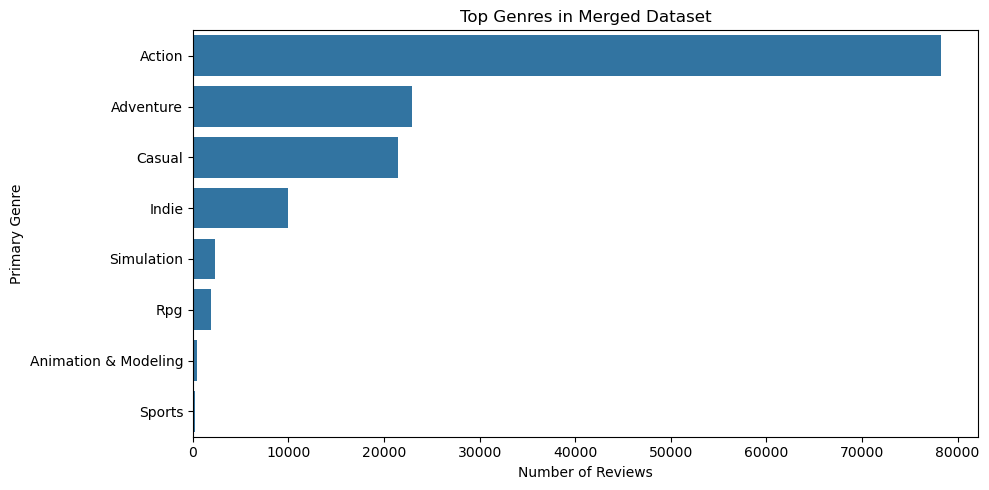

In [36]:
# Filter to matched rows only
matched_df = merged_df[merged_df["primary_genre"].notna()].copy()

# Clean up genre names (remove spaces, normalize case)
matched_df["primary_genre"] = matched_df["primary_genre"].str.strip().str.title()

# Define the 8 main genres we want to display
core_genres = [
    "Action", "Adventure", "Rpg", "Indie", "Casual",
    "Sports", "Animation & Modeling", "Simulation"
]

# Filter only those
filtered_df = matched_df[matched_df["primary_genre"].isin(core_genres)].copy()

# Count by genre
genre_counts = filtered_df["primary_genre"].value_counts()

# Summary
unique_games = filtered_df["AppID"].nunique()
print(f"✅ Unique games with core genre info: {unique_games:,}")
print(f"🎮 Unique core genres: {len(genre_counts)}\n")
display(genre_counts)

# Clean barplot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.barplot(
    x=genre_counts.values,
    y=genre_counts.index,
)
plt.title("Top Genres in Merged Dataset")
plt.xlabel("Number of Reviews")
plt.ylabel("Primary Genre")
plt.tight_layout()
plt.show()

#### 🔍 Results: Genre Coverage Check

- **99,755 unique games** have valid genre info  
- **8 main genres** show up: Action, Adventure, Casual, Indie, Simulation, RPG, Animation & Modeling, Sports  
- Reviews lean heavily toward **Action**

Even with the uneven split, the dataset still gives a solid base for emotional analysis in the hybrid model.

---

## 7. Export Final Merged Dataset

The merge is complete.  
The dataset now includes `psych_genre` plus `AppID`, `Name`, and all genre fields.

#### Saved Versions
- **`03_games_merged_full.csv`**  
  All games with genre metadata  
  (good for broad analysis and dashboards)

- **`03_games_merged_reviews.csv`**  
  Games that include real player reviews  
  (used for emotion modeling and ML steps)

Both files are ready for the next phase, where psychology-aligned genres will connect with player emotion data.

In [37]:
OUT_FULL = DATA_DIR / "03_games_merged_full.csv"
OUT_FILTERED = DATA_DIR / "03_games_merged_reviews.csv"

# Save both versions
merged_df.to_csv(OUT_FULL, index=False)
filtered_df.to_csv(OUT_FILTERED, index=False)

print(f"✅ Saved full merged dataset: {OUT_FULL.name} ({merged_df.shape[0]:,} rows)")
print(f"✅ Saved filtered review-only dataset: {OUT_FILTERED.name} ({filtered_df.shape[0]:,} rows)")

✅ Saved full merged dataset: 03_games_merged_full.csv (142,732 rows)
✅ Saved filtered review-only dataset: 03_games_merged_reviews.csv (137,479 rows)


---

## 8. Insights & Next Steps
  
The merge is complete.  
Reviews are now linked to each game’s genre tags.  
This sets up the move into emotion scoring.

#### ➡️ Next
**`04_generate_emotion_scores_full.ipynb`**  

Here I will:
- Run NRC and VADER to score each review  
- Build emotion features (`primary_emotion`, `emotion_intensity`, `emotion_richness`)  
- Prepare the data for hybrid relief mapping and genre–emotion analysis  

This is where the emotional layer begins and raw reviews turn into clear signals of how players feel.